<a href="https://colab.research.google.com/github/nagaditya39/ESRGAN-ImageSR-Colab/blob/main/checkEval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#utils.py

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from pathlib import Path
import re

import shutil
from google.colab import drive
from google.colab import files

def read_image(img_path):
    base=os.path.basename(img_path)
    ext = os.path.splitext(base)[1]
    assert ext in ['.png', '.jpg', '.jpeg', '.JPEG']
    image = tf.io.read_file(img_path)
    if ext == '.png':
        image = tf.image.decode_png(image, channels=3)
    else:
        image = tf.image.decode_jpeg(image, channels=3)
    return image

# def create_lr_hr_pair(img_path, scale):
#     image = read_image(img_path)
#     lr_height, lr_width = image.shape[0] // scale, image.shape[1] // scale
#     hr_height, hr_width = lr_height * scale, lr_width * scale
#     hr_image = image[:hr_height, :hr_width, :]
#     lr_shape = [lr_height, lr_width]
#     lr_image = tf.image.resize(hr_image, lr_shape, method=tf.image.ResizeMethod.BICUBIC)

#     return lr_image, hr_image

def scale_image_0_1_range(image):
    image = image / 255
    red_max = tf.reduce_max(image, axis=None)
    red_min = tf.reduce_min(image, axis=None)
    if red_max > 1 or red_min < 0:
        image = tf.clip_by_value(
            image, 0, 1, name=None
        )
    return image


# def unscale_image_0_255_range(image):
#     image = image * 255
#     red_max = tf.reduce_max(image, axis=None)
#     red_min = tf.reduce_min(image, axis=None)
#     if red_max > 255 or red_min < 0:
#         image = tf.clip_by_value(
#             image, 0, 255, name=None
#         )
#     return image

def tensor2img(tensor):
    return (np.squeeze(tensor.numpy()).clip(0, 1) * 255).astype(np.uint8)


def save_image_grid(lr, hr, ref=None, save_path=None):
    lr_title = "lr: {}".format(lr.shape)
    hr_title = "hr: {}".format(hr.shape)
    images = [lr, hr]
    titles = [lr_title, hr_title]
    if ref is not None:
        ref_title = "ref: {}".format(ref.shape)
        images += [ref]
        titles += [ref_title]
        fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(20, 10))


    for i, (img, title) in enumerate(zip(images, titles)):
        axes[i].imshow(img)
        axes[i].set_title(title, fontsize = 20)
        axes[i].axis('off')
    # fig.savefig(save_path, bbox_inches = 'tight', pad_inches = 0.25)
    plt.show()


def load_models_for_epoch(base_path, epoch_num, is_gan=False):
    # """Loads model(s) for a specific epoch."""
    model_path = f"{base_path}_epoch_{epoch_num}.h5"
    if not Path(model_path).exists():
        raise ValueError(f"Model for epoch {epoch_num} not found at {model_path}")
    model = tf.keras.models.load_model(model_path)
    if is_gan:  # Load discriminator as well for GAN training
        disc_path = f"{base_path.replace('esrgan', 'disc_gan')}_epoch_{epoch_num}.h5"
        discriminator = tf.keras.models.load_model(disc_path)
        return model, discriminator
    return model

def get_available_epochs(base_path):
    # """Returns a list of available epoch numbers from saved model filenames."""
    model_dir = Path(base_path).parent
    pattern = re.compile(r"_epoch_(\d+)\.h5")
    epochs = []
    for filename in model_dir.glob("*.h5"):
        match = pattern.search(filename.name)
        if match:
            epochs.append(int(match.group(1)))
    return sorted(epochs)


def download_saved_folder(saved_folder_path, download_location="local", drive_folder_id=None):
    # """Downloads the saved folder to the specified location."""

    if download_location == "local":
        # Download to local machine (assuming you are using Colab)
        shutil.make_archive(saved_folder_path, 'zip', saved_folder_path)
        zipped_filename = saved_folder_path + ".zip"
        files.download(zipped_filename)

    elif download_location == "drive" and drive_folder_id:
        # Download to Google Drive (Colab only)
        drive.mount('/content/gdrive')  # Mount Google Drive
        destination_path = "/content/gdrive/My Drive/" + drive_folder_id
        shutil.make_archive(saved_folder_path, 'zip', saved_folder_path)
        zipped_filename = saved_folder_path + ".zip"
        shutil.move(zipped_filename, destination_path)
        print(f"Saved folder uploaded to Google Drive folder ID: {drive_folder_id}")

    else:
        print(f"[!] Invalid download location or missing Drive folder ID.")

In [2]:
#metrics.py

import tensorflow as tf

def calculate_psnr(img1, img2):
    #img1 and img2 have range [0, 255]
    #psnr = 20 * np.log10(255.0 / np.sqrt(np.mean((img1 - img2)**2)))
    return tf.image.psnr(img1, img2, max_val=255)

def calculate_ssim(hr, generated_hr):
    #hr and generated_hr have range [0, 255]
    return tf.image.ssim(hr, generated_hr, max_val=255)

In [3]:
# esrgan.py
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, PReLU, Dropout, Dense
from tensorflow.keras.layers import BatchNormalization, Concatenate, Lambda, Add


def residual_dense_block(input, filters):
    x1 = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(input)
    x1 = LeakyReLU(0.2)(x1)
    x1 = Concatenate()([input, x1])

    x2 = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x1)
    x2 = LeakyReLU(0.2)(x2)
    x2 = Concatenate()([input, x1, x2])

    x3 = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x2)
    x3 = LeakyReLU(0.2)(x3)
    x3 = Concatenate()([input, x1, x2, x3])

    x4 = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x3)
    x4 = LeakyReLU(0.2)(x4)
    x4 = Concatenate()([input, x1, x2, x3, x4])

    x5 = Conv2D(filters=filters, kernel_size=3, strides=1, padding='same')(x4)
    x5 = Lambda(lambda x: x * 0.2)(x5)
    x = Add()([x5, input])

    return x

def rrdb(input, filters):
    x = residual_dense_block(input, filters)
    x = residual_dense_block(x, filters)
    x = residual_dense_block(x, filters)
    x = Lambda(lambda x: x * 0.2)(x)
    out = Add()([x, input])
    return out

def sub_pixel_conv2d(scale_factor=2, **kwargs):
    return Lambda(lambda  x: tf.nn.depth_to_space(x, scale_factor), **kwargs)

def upsample(input_tensor, filters, scale_factor=2):
    x = Conv2D(filters=filters*4, kernel_size=3, strides=1, padding='same')(input_tensor)
    x = sub_pixel_conv2d(scale_factor=scale_factor)(x)
    x = PReLU(shared_axes=[1,2])(x)
    return x

def rrdb_net(input_shape=(None, None, 3), filters=64, scale_factor=4, name='RRDB_model'):
    lr_image = Input(shape=input_shape, name='input')

    #Pre-residual
    x_start = Conv2D(filters, kernel_size=3, strides=1, padding='same')(lr_image)
    x_start = LeakyReLU(0.2)(x_start)

    #Residual block
    x = rrdb(x_start, filters)

    #Post Residual block
    x = Conv2D(filters,  kernel_size=3, strides=1, padding='same')(x)
    x = Lambda(lambda x: x * 0.2)(x)
    x = Add()([x, x_start])

    #Upsampling
    x = upsample(x, filters, scale_factor)

    x = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = LeakyReLU(0.2)(x)
    out = Conv2D(filters=3, kernel_size=3, strides=1, padding='same')(x)

    return Model(inputs=lr_image, outputs=out, name=name)

def conv2d_block(input, filters, strides=1, bn=True):
    x = Conv2D(filters, kernel_size=3, strides=strides, padding='same')(input)
    x = LeakyReLU(0.2)(x)
    if bn:
        x = BatchNormalization(momentum=0.8)(x)
    return x


def discriminator_net(input_shape=(None, None, 3), filters=64, name='Discriminator'):
    img = Input(shape=input_shape)

    x = conv2d_block(img, filters, bn=False)
    x = conv2d_block(x, filters, strides=2)
    x = conv2d_block(x, filters*2)
    x = conv2d_block(x, filters*2, strides=2)
    x = conv2d_block(x, filters*4)
    x = conv2d_block(x, filters*4, strides=2)
    x = conv2d_block(x, filters*8)
    x = conv2d_block(x, filters*8, strides=2)
    x = Dense(filters*16)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Dropout(0.4)(x)
    x = Dense(1)(x)

    return Model(inputs=img, outputs=x, name=name)

[*] load ckpt from ./saved/checkpoints/psnr/ckpt-8000.
[***] Image: lr_im0005, PSNR: 33.76329803466797, SSIM: 0.9025238156318665


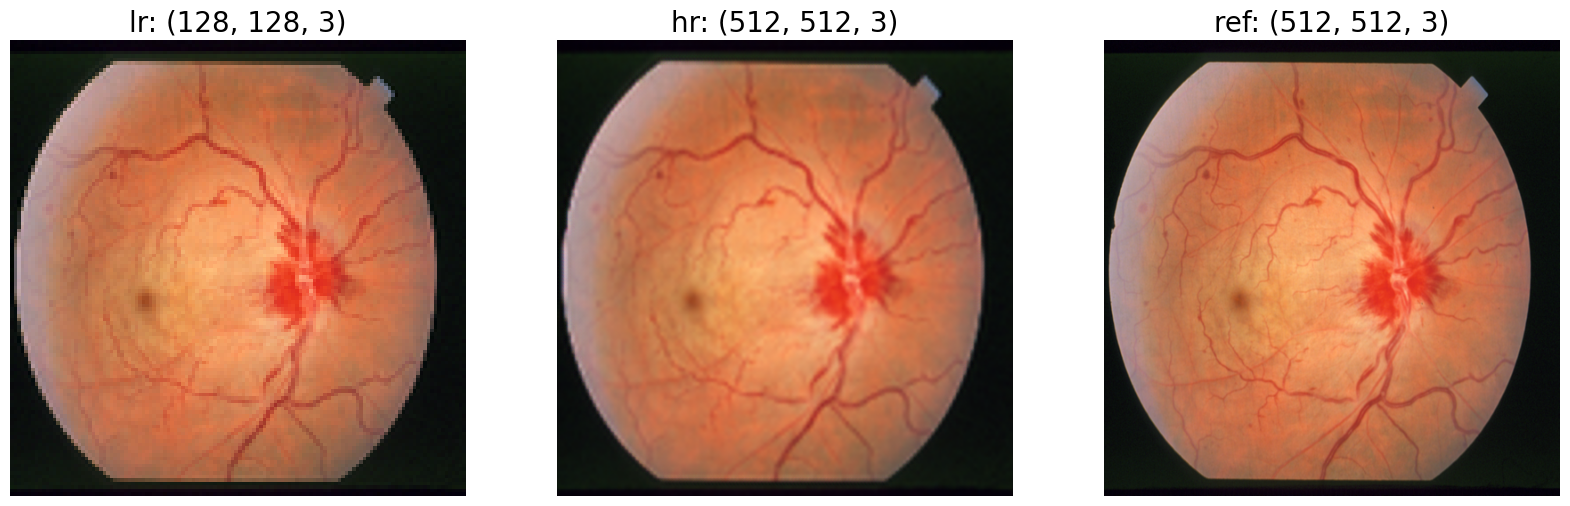

[***] Image: lr_im0003, PSNR: 34.77260971069336, SSIM: 0.8987863063812256


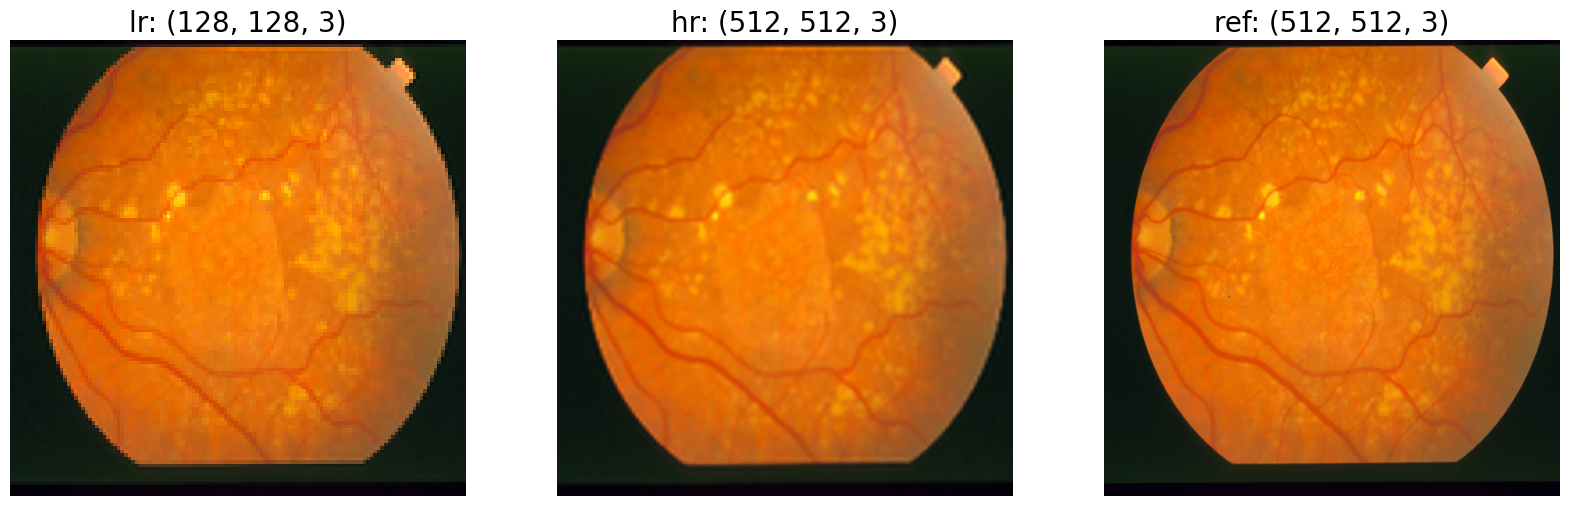

[***] Image: lr_im0004, PSNR: 37.571327209472656, SSIM: 0.9417016506195068


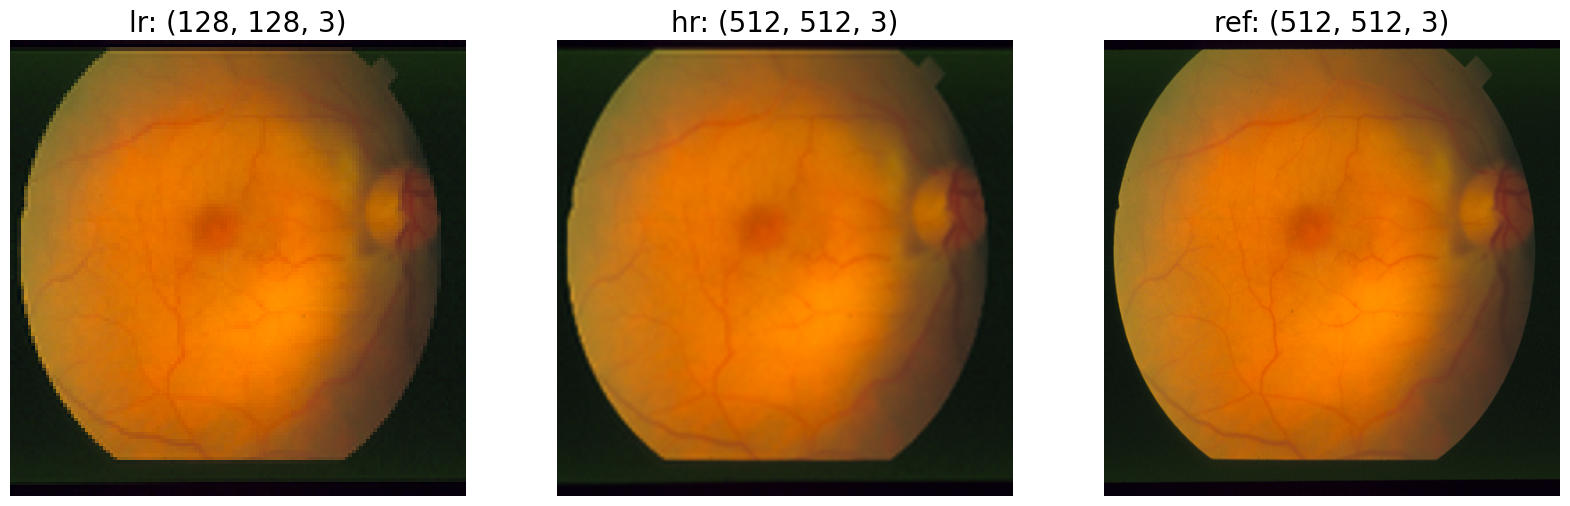

[***] Image: lr_im0002, PSNR: 37.11054229736328, SSIM: 0.9293991923332214


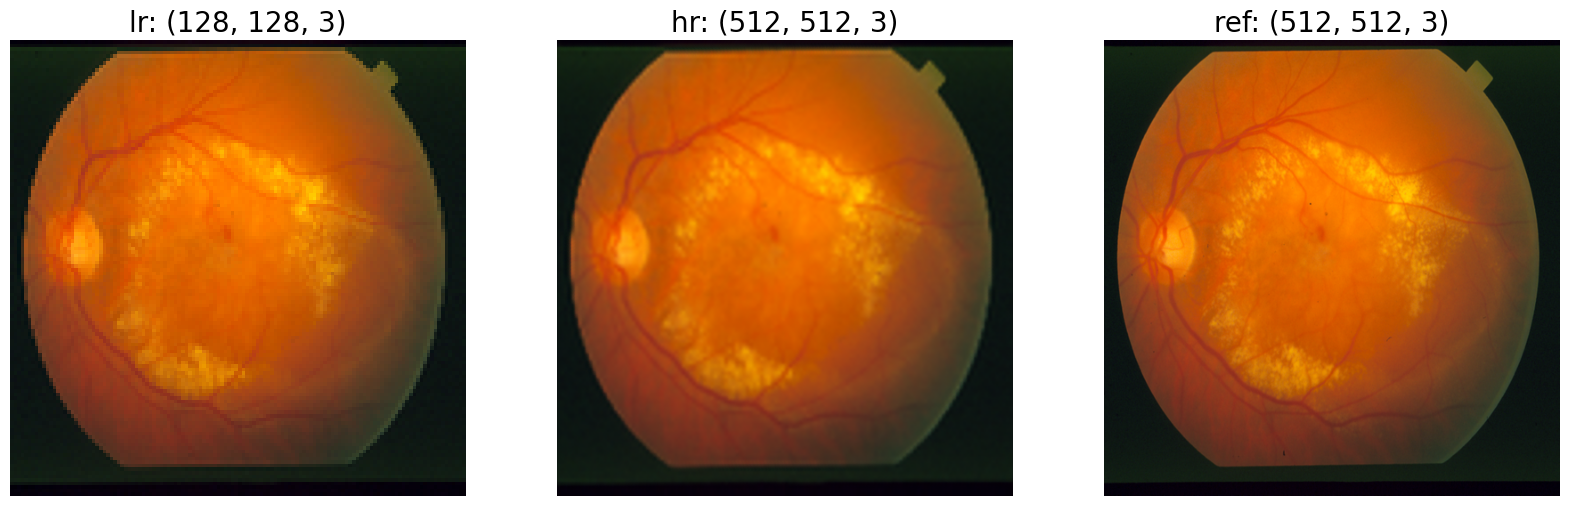

[***] Image: lr_im0001, PSNR: 37.39273452758789, SSIM: 0.9365277290344238


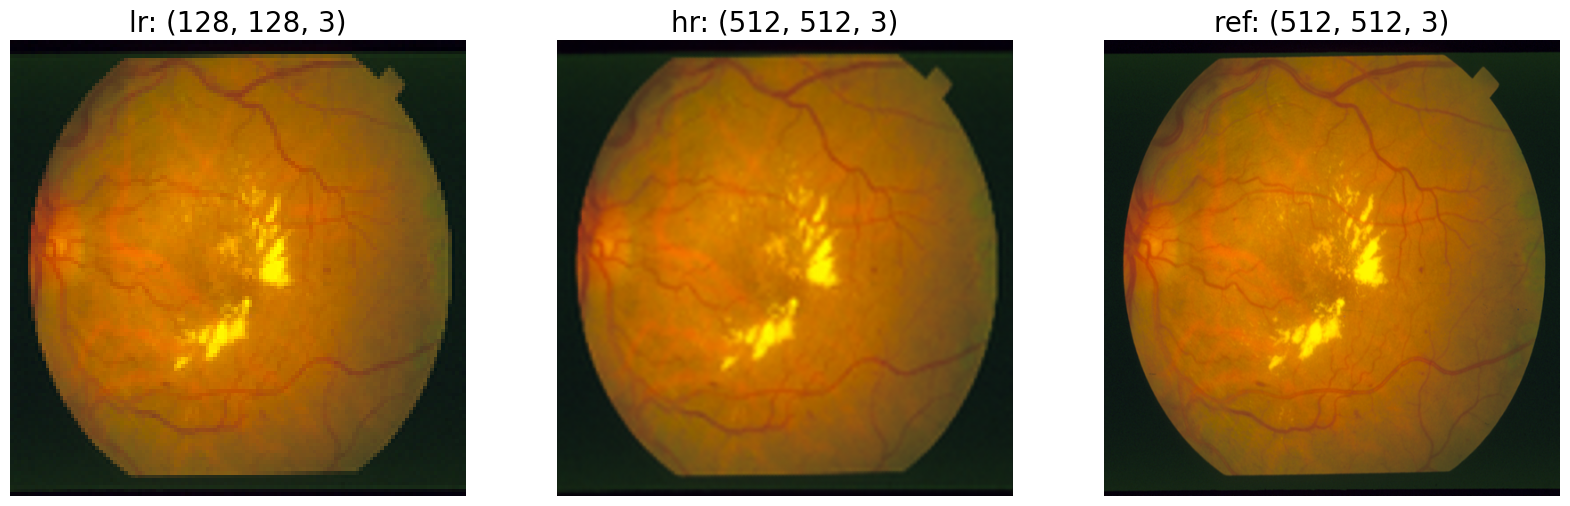

In [4]:
#demo.py (esrgan evaluate)

import os
import glob
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.models import load_model
# from modules.esrgan import rrdb_net
# from modules.utils import read_image, scale_image_0_1_range, tensor2img
# from modules.utils import save_image_grid



SCALE = 4
INPUT_SHAPE=(None, None, 3)

FROM_CHECKPOINT = True
MODEL_PATH = "./saved/models/psnr"
# MODEL_PATH = "./saved/models/esrgan"
CHECKPOINT_PATH = "./saved/checkpoints/psnr"
# CHECKPOINT_PATH = "./saved/checkpoints/esrgan"

IMG_DIR = "./images/input"  # Path to the directory containing LR images
GT_DIR = "./images/ground_truth"  # Path to the directory containing ground truth HR images (optional)
SAVE_DIR = "./images/results"  # Directory to save the upscaled images

Path(SAVE_DIR).mkdir(parents=True, exist_ok=True)

def main():

    model = rrdb_net(input_shape=INPUT_SHAPE,scale_factor=SCALE)

    checkpoint = tf.train.Checkpoint(model=model)

    if tf.train.latest_checkpoint(CHECKPOINT_PATH) and FROM_CHECKPOINT:
            status = checkpoint.restore(tf.train.latest_checkpoint(CHECKPOINT_PATH))
            status.expect_partial()   # suppress warnings or else it spam
            print("[*] load ckpt from {}.".format(
            tf.train.latest_checkpoint(CHECKPOINT_PATH)))
    else:
        if os.path.isfile(MODEL_PATH):
            h5_model = load_model(MODEL_PATH, custom_objects={'tf': tf})
            weights = h5_model.get_weights()
            model.set_weights(weights)
            print("[*] load model weights from {}.".format(
            MODEL_PATH))
        else:
            print("[*] Cannot find ckpt or h5 model file.")
            exit()

    if os.path.isdir(IMG_DIR):  # Check if it's a directory
        for img_path in glob.glob(os.path.join(IMG_DIR, "*.png")):  # Assuming PNG images
            # Extract filename without extension
            filename = os.path.splitext(os.path.basename(img_path))[0]

             # Load LR image
            lr_image = read_image(img_path)
            lr_image = scale_image_0_1_range(lr_image)
            lr_image = tf.expand_dims(lr_image, axis=0)

            base_filename = filename[2:]

            # Load ground truth HR image (if available)
            hr_filename = f"hr{base_filename}.png"  # Add "hr" prefix and extension
            hr_img_path = os.path.join(GT_DIR, hr_filename)
            if os.path.exists(hr_img_path):
                hr_image = read_image(hr_img_path)
            else:
                hr_image = None

            # Generate HR image
            generated_hr = model(lr_image)
            generated_hr_image = tensor2img(generated_hr)
            unscale_lr_image = tensor2img(lr_image)

            # Calculate metrics (if ground truth is available)
            if hr_image is not None:
                psnr = calculate_psnr(hr_image, generated_hr_image)
                ssim = calculate_ssim(hr_image, generated_hr_image)
                print(f"[***] Image: {filename}, PSNR: {psnr}, SSIM: {ssim}")

            # Save image grid with LR, generated HR, and optionally ground truth
            save_path = os.path.join(SAVE_DIR, f"{filename}_upscaled.png")
            save_image_grid(unscale_lr_image, generated_hr_image, hr_image, save_path=save_path)

    else:
        print(f"[!] Invalid image directory: {IMG_DIR}")



if __name__ == '__main__':
    main()

